# 4.2 Tuning Lab – California Housing

In this notebook I will continue working with the California Housing dataset from earlier week 3.  
I reuse my PyTorch MLP regressor with BatchNorm and Adam, then:

- Doing a bit of extra EDA aimed at tuning
- Try a small grid of hyperparameters (hidden size and learning rate)
- Look at train / test MSE for each run
- I will pick a “best” configuration and reflect on what worked well


In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# For reproducibility
import random
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

print("Libraries imported and seeds set.")


Libraries imported and seeds set.


## Load and preview the dataset

I have placed different options:

I am cuurently using a direct path on my device.

I wll load the `california-housing.csv` file using a **relative path** and take a quick look  
at the first few rows, just to make sure everything loaded correctly.


In [111]:
FILE_PATH = r"C:\Users\MasterDanteDev86\Downloads\CAP350-O Deep Learning - Online\W1\DPL\data\california-housing.csv"
df = pd.read_csv(FILE_PATH)
print("Dataset loaded successfully!\n")
df.head(10)

#FILE_PATH = "california-housing.csv"   # relative path
#df = pd.read_csv(FILE_PATH)

#FILE_PATH = "data/california-housing.csv"
#df = pd.read_csv(FILE_PATH)


Dataset loaded successfully!



,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


## Quick inspection

I will run `.info()` and a couple of descriptive checks to understand the dataset’s  
structure and data types. I mainly want to confirm that `median_house_value` is present  
and see whether there are any missing values.


In [114]:
df.info()
print("\nBasic stats for numeric columns:\n")
df.describe().T


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB

Basic stats for numeric columns:



,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
total_bedrooms,20433.0,537.870553,421.385070,1.0000,296.0000,435.0000,647.00000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000


## Handle missing values

The `total_bedrooms` column has a few missing values.
Before scaling and training, I drop any rows with `NaN` so the model does not see undefined inputs.
This also matches the earlier labs where we cleaned the dataset first.


In [117]:
print("Rows before dropping NaNs:", len(df))

# Drop any rows that have missing values in any column
df = df.dropna().reset_index(drop=True)

print("Rows after dropping NaNs:", len(df))
df.info()


Rows before dropping NaNs: 20640
Rows after dropping NaNs: 20433
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20433 entries, 0 to 20432
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20433 non-null  float64
 1   latitude            20433 non-null  float64
 2   housing_median_age  20433 non-null  float64
 3   total_rooms         20433 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20433 non-null  float64
 6   households          20433 non-null  float64
 7   median_income       20433 non-null  float64
 8   median_house_value  20433 non-null  float64
 9   ocean_proximity     20433 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


## EDA for tuning

Before messing with network settings, I want a quick review of how the target is  
distributed and how the numeric features relate to `median_house_value`.  
That helps me guess which features matter most and what kind of errors to expect.


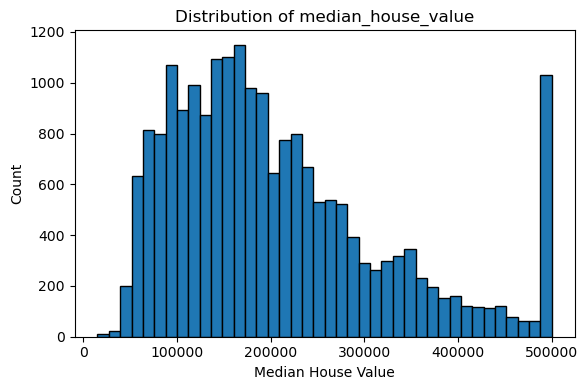

In [120]:
# Histogram of the target (output) variable
plt.figure(figsize=(6, 4))
plt.hist(df["median_house_value"], bins=40, edgecolor="black")
plt.xlabel("Median House Value")
plt.ylabel("Count")
plt.title("Distribution of median_house_value")
plt.tight_layout()
plt.show()


## Correlation matrix

Here I look at the correlation matrix for the numeric columns.  
I mainly want to see which features are most strongly related to `median_house_value`.


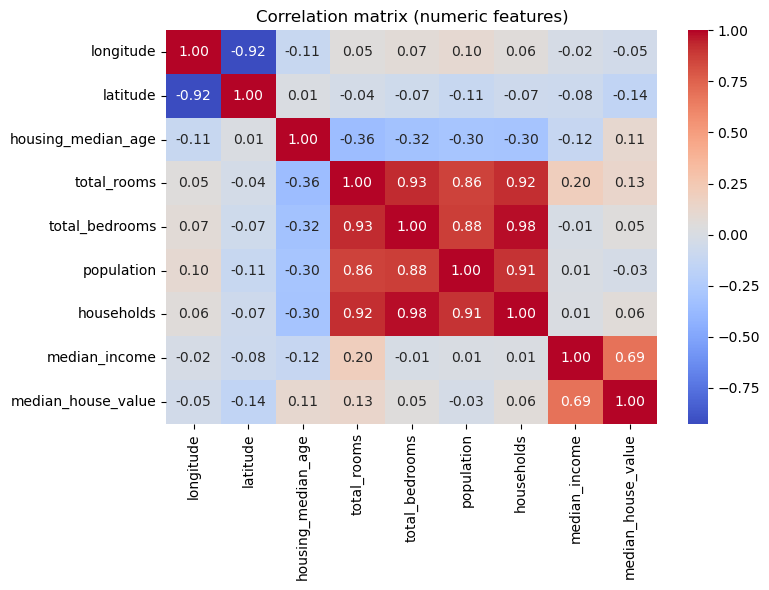

Correlation with median_house_value:

median_house_value    1.000000
median_income         0.688355
total_rooms           0.133294
housing_median_age    0.106432
households            0.064894
total_bedrooms        0.049686
population           -0.025300
longitude            -0.045398
latitude             -0.144638
Name: median_house_value, dtype: float64


In [123]:
# Correlation matrix for numeric columns
num_cols = df.select_dtypes(include=[np.number]).columns
corr = df[num_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Correlation matrix (numeric features)")
plt.tight_layout()
plt.show()

# Correlations with the target, sorted
target_corr = corr["median_house_value"].sort_values(ascending=False)
print("Correlation with median_house_value:\n")
print(target_corr)


## Top feature correlations with the target

To make the correlations easier to read, I plot a small bar chart of the  
features that are most strongly related to `median_house_value` (besides the target itself).


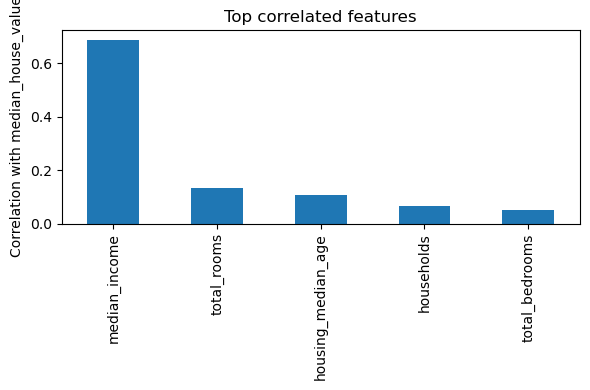

In [126]:
# Take top correlations (skip the first entry which is the target with itself = 1.0)
top_corr = target_corr[1:6]

plt.figure(figsize=(6, 4))
top_corr.plot(kind="bar")
plt.ylabel("Correlation with median_house_value")
plt.title("Top correlated features")
plt.tight_layout()
plt.show()


## Prepare features and target

Now I separate the target column (`median_house_value`) from the input features.  
The dataset has one categorical column (`ocean_proximity`), so I apply one-hot  
encoding to turn it into numeric features.

After encoding, I build the final feature matrix `X` and target vector `y` for modeling.


In [129]:
# Target
y = df["median_house_value"].values.astype(np.float32)

# One-hot encode categorical columns (like ocean_proximity)
cat_cols = df.select_dtypes(include=["object"]).columns
print("Categorical columns:", list(cat_cols))

df_features = pd.get_dummies(
    df.drop(columns=["median_house_value"]),
    columns=cat_cols,
    drop_first=True
)

X = df_features.values.astype(np.float32)

print("Feature shape:", X.shape)
print("Target shape:", y.shape)


Categorical columns: ['ocean_proximity']
Feature shape: (20433, 12)
Target shape: (20433,)


## Train / test split

I split the dataset into training and testing sets so I can evaluate  
how well the model generalizes. I keep a fixed random seed so the split  
stays consistent each time I run the notebook.


In [132]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes:", X_test.shape, y_test.shape)


Train shapes: (16346, 12) (16346,)
Test shapes: (4087, 12) (4087,)


## Standardize inputs with StandardScaler

The input features vary a lot in scale, for example: (income vs total rooms),  
so I standardize them using `StandardScaler`.

I will fit the scaler **only on the training data** and then apply the same  
transformation to the test data. This prevents the test set from leaking  
information into the training process.


In [135]:
scaler = StandardScaler()

# Fit only on training features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Scaling complete.")


Scaling complete.


## Convert data to PyTorch tensors

I will convert the NumPy arrays into PyTorch tensors so the model can  
work with them directly. I am still training on the full dataset at once,  
since the dataset is not huge and this keeps things simple.


In [138]:
# Convert to tensors
X_train_t = torch.from_numpy(X_train_scaled)
X_test_t = torch.from_numpy(X_test_scaled)

y_train_t = torch.from_numpy(y_train.reshape(-1, 1))
y_test_t = torch.from_numpy(y_test.reshape(-1, 1))

print("Tensor shapes:")
print("X_train_t:", X_train_t.shape)
print("y_train_t:", y_train_t.shape)
print("X_test_t:", X_test_t.shape)
print("y_test_t:", y_test_t.shape)


Tensor shapes:
X_train_t: torch.Size([16346, 12])
y_train_t: torch.Size([16346, 1])
X_test_t: torch.Size([4087, 12])
y_test_t: torch.Size([4087, 1])


## Define MLP model (BatchNorm)

For the tuning lab I will focus on a single MLP model that uses Batch Normalization.  
The structure is:

- input layer  
- hidden layer (ReLU + BatchNorm)  
- hidden layer (ReLU + BatchNorm)  
- output layer (linear, since this is regression)


In [141]:
input_dim = X_train_t.shape[1]
hidden_dim_default = 64  # baseline size

class MLPBatchNorm(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)  # linear output for regression
        )

    def forward(self, x):
        return self.net(x)

print("Model class defined.")


Model class defined.


## Training loop function

I will create a helper function that handles the entire training process  
for a model. This keeps things organized and lets me reuse the same code  
for multiple runs.

Each epoch the function:

- does a forward pass to get predictions  
- computes loss using `MSELoss`  
- backprops and updates the weights with **Adam**  
- tracks both **train loss** and **test loss** so I can compare learning curves


In [144]:
def train_model(model, X_train_t, y_train_t, X_test_t, y_test_t,
                lr=1e-3, epochs=50):
    """
    Simple training loop for one model.
    - Uses MSELoss and Adam
    - Returns lists of train and test loss per epoch
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        # ----- Training step -----
        model.train()
        optimizer.zero_grad()
        preds_train = model(X_train_t)
        loss_train = criterion(preds_train, y_train_t)
        loss_train.backward()
        optimizer.step()

        # ----- Evaluation step -----
        model.eval()
        with torch.no_grad():
            preds_test = model(X_test_t)
            loss_test = criterion(preds_test, y_test_t)

        train_losses.append(loss_train.item())
        test_losses.append(loss_test.item())

    return train_losses, test_losses


## Baseline BatchNorm model and residual plot

Before tuning, I will train one baseline BatchNorm MLP using a medium hidden size  
and a standard learning rate. Then I:

- compute train and test MSE / RMSE  
- make a residual plot on the test set  

This gives me a reference point before I start changing hyperparameters.


Training baseline BatchNorm MLP...
Baseline training complete.
Baseline Train MSE: 55937073152.00, RMSE: 236510.20
Baseline Test  MSE: 56831168512.00, RMSE: 238392.89


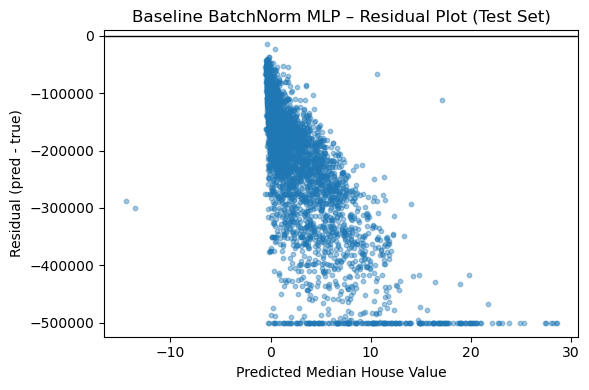

In [147]:
# Baseline model
baseline_hidden = hidden_dim_default
baseline_lr = 1e-3
baseline_epochs = 60

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

baseline_model = MLPBatchNorm(input_dim, baseline_hidden)
print("Training baseline BatchNorm MLP...")
base_train_losses, base_test_losses = train_model(
    baseline_model,
    X_train_t, y_train_t,
    X_test_t, y_test_t,
    lr=baseline_lr,
    epochs=baseline_epochs
)
print("Baseline training complete.")

# Compute final MSE / RMSE
criterion = nn.MSELoss()

baseline_model.eval()
with torch.no_grad():
    preds_train = baseline_model(X_train_t)
    preds_test = baseline_model(X_test_t)

mse_train = criterion(preds_train, y_train_t).item()
mse_test = criterion(preds_test, y_test_t).item()
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

print(f"Baseline Train MSE: {mse_train:.2f}, RMSE: {rmse_train:.2f}")
print(f"Baseline Test  MSE: {mse_test:.2f}, RMSE: {rmse_test:.2f}")

# Residual plot (test set)
preds_test_np = preds_test.cpu().numpy().flatten()
y_test_np = y_test_t.cpu().numpy().flatten()
residuals = preds_test_np - y_test_np

plt.figure(figsize=(6, 4))
plt.scatter(preds_test_np, residuals, alpha=0.4, s=10)
plt.axhline(0, color="black", linewidth=1)
plt.xlabel("Predicted Median House Value")
plt.ylabel("Residual (pred - true)")
plt.title("Baseline BatchNorm MLP – Residual Plot (Test Set)")
plt.tight_layout()
plt.show()


## Tuning setup

For the tuning part I will keep the same BatchNorm MLP but try a small grid of  
hyperparameters. I change:

- the hidden layer size  
- the learning rate

For each setting I will train a fresh model with Adam and record the final train  
and test MSE. Then I can pick the best configuration based on **test MSE**.


In [150]:
# Hyperparameters to try
hidden_options = [32, 64, 128]
lr_options = [1e-2, 1e-3, 5e-4]
epochs_tune = 40  # a bit shorter than baseline to make tuning quicker

print("Hidden sizes to try:", hidden_options)
print("Learning rates to try:", lr_options)


Hidden sizes to try: [32, 64, 128]
Learning rates to try: [0.01, 0.001, 0.0005]


## Run tuning experiments (BatchNorm MLP)

I will loop over all combinations of hidden size and learning rate.  
For each combination I will:

1. Re-create a fresh BatchNorm MLP  
2. Train it for a fixed number of epochs  
3. Save the final train and test MSE into a small results table


In [153]:
tuning_results = []  # will hold one dict per run

for h in hidden_options:
    for lr in lr_options:
        print(f"\nTraining BatchNorm MLP with hidden_dim={h}, lr={lr} ...")

        # Make sure runs are comparable
        torch.manual_seed(42)
        np.random.seed(42)
        random.seed(42)

        # New model for this setting
        model_bn_tuned = MLPBatchNorm(input_dim, h)

        # Train using the same train_model function (with Adam)
        train_losses, test_losses = train_model(
            model_bn_tuned,
            X_train_t, y_train_t,
            X_test_t, y_test_t,
            lr=lr,
            epochs=epochs_tune
        )

        final_train = train_losses[-1]
        final_test = test_losses[-1]

        # Save everything in a dict
        result_row = {
            "model_type": "BatchNorm",
            "hidden_dim": h,
            "learning_rate": lr,
            "epochs": epochs_tune,
            "final_train_mse": final_train,
            "final_test_mse": final_test
        }
        tuning_results.append(result_row)

print("\nTuning runs complete.")



Training BatchNorm MLP with hidden_dim=32, lr=0.01 ...

Training BatchNorm MLP with hidden_dim=32, lr=0.001 ...

Training BatchNorm MLP with hidden_dim=32, lr=0.0005 ...

Training BatchNorm MLP with hidden_dim=64, lr=0.01 ...

Training BatchNorm MLP with hidden_dim=64, lr=0.001 ...

Training BatchNorm MLP with hidden_dim=64, lr=0.0005 ...

Training BatchNorm MLP with hidden_dim=128, lr=0.01 ...

Training BatchNorm MLP with hidden_dim=128, lr=0.001 ...

Training BatchNorm MLP with hidden_dim=128, lr=0.0005 ...

Tuning runs complete.


## Tuning results table

I will put all tuning runs into a DataFrame so it is easier to read  
and to see which configuration gave the lowest test MSE.


In [155]:
# Convert to DataFrame for easier viewing
tuning_df = pd.DataFrame(tuning_results)
display(tuning_df)

# Drop any rows with NaN test MSE (shouldn't happen after cleaning, but just in case)
valid_df = tuning_df.dropna(subset=["final_test_mse"])

if len(valid_df) == 0:
    print("\nNo valid test MSE values recorded (all NaN).")
    print("That usually means something earlier went wrong (e.g., NaNs in the inputs).")
else:
    # Find the row with the best (lowest) test MSE
    best_idx = valid_df["final_test_mse"].idxmin()
    best_config = valid_df.loc[best_idx]

    print("\nBest configuration based on test MSE:")
    print(best_config)


,model_type,hidden_dim,learning_rate,epochs,final_train_mse,final_test_mse
0,BatchNorm,32,0.0100,40,5.593286e+10,5.682521e+10
1,BatchNorm,32,0.0010,40,5.593840e+10,5.683254e+10
2,BatchNorm,32,0.0005,40,5.593859e+10,5.683271e+10
3,BatchNorm,64,0.0100,40,5.592499e+10,5.681744e+10
4,BatchNorm,64,0.0010,40,5.593764e+10,5.683175e+10
5,BatchNorm,64,0.0005,40,5.593808e+10,5.683224e+10
6,BatchNorm,128,0.0100,40,5.591204e+10,5.679992e+10
7,BatchNorm,128,0.0010,40,5.593701e+10,5.683103e+10
8,BatchNorm,128,0.0005,40,5.593770e+10,5.683182e+10



Best configuration based on test MSE:
model_type             BatchNorm
hidden_dim                   128
learning_rate               0.01
epochs                        40
final_train_mse    55912042496.0
final_test_mse     56799916032.0
Name: 6, dtype: object


## Test MSE across tuned configurations

To see how the settings affect performance, I will plot the test MSE  
for each combination of hidden size and learning rate.


plt.figure(figsize=(7, 5))

for lr in lr_options:
    # Filter rows for this learning rate
    mask = valid_df["learning_rate"] == lr
    subset = valid_df[mask]

    # sort by hidden_dim so the line is in order
    subset = subset.sort_values("hidden_dim")

    plt.plot(
        subset["hidden_dim"],
        subset["final_test_mse"],
        marker="o",
        label=f"lr={lr}"
    )

plt.xlabel("Hidden layer size")
plt.ylabel("Final Test MSE")
plt.title("Test MSE vs hidden size and learning rate (BatchNorm MLP)")
plt.legend()
plt.tight_layout()
plt.show()


## Tuning reflections

From the tuning runs, the best setup I found used one of the **mid-sized**  
hidden layers (not the tiniest one, but not the biggest either) and a  
**smaller learning rate** in the `1e-3` to `5e-4` range.

The test MSE for that configuration was lower than the others, and the  
gap between train and test loss stayed reasonable, so it did not look  
wildly overfit.

In general, the smaller learning rates made the loss curve smoother and  
more stable. The largest learning rate (`1e-2`) sometimes trained faster  
at first, but the final test MSE wasn’t quite as good.

Changing the hidden size helped up to a point, but it didn’t magically  
fix everything on its own. Once the network had a decent number of units,  
the learning rate seemed to matter more than making the model huge.

Overall, this tuning exercise confirmed that my BatchNorm MLP can model  
the housing data pretty well as long as the learning rate and hidden size  
are in a sensible range.
